In [26]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import seaborn as sns
import scipy.stats as stats

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, plot=True):
    """
    Evaluate regression predictions for IMD rank.
    
    Parameters:
    - y_true: array-like, true IMD ranks
    - y_pred: array-like, predicted IMD ranks
    - plot: bool, whether to show scatter plot of predicted vs actual
    
    Returns:
    - metrics: dictionary with RMSE, MAE, R2, Spearman correlation
    """
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    print("Model evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel("True IMD Rank")
        plt.ylabel("Predicted IMD Rank")
        plt.title("Predicted vs Actual IMD Rank")
        plt.grid(True)
        plt.show()

    return metrics

### Get imd data

In [108]:
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {
    "LSOA code (2011)": "LSOA11CD",
    "LSOA name (2011)": "lsoa_2011_name",
    "Local Authority District code (2019)": "lad_2019_code",
    "Local Authority District name (2019)": "lad_2019_name",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile",
    "Income Rank (where 1 is most deprived)": "income_rank",
    "Income Decile (where 1 is most deprived 10% of LSOAs)": "income_decile",
    "Employment Rank (where 1 is most deprived)": "employment_rank",
    "Employment Decile (where 1 is most deprived 10% of LSOAs)": "employment_decile",
    "Education, Skills and Training Rank (where 1 is most deprived)": "education_rank",
    "Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)": "education_decile",
    "Health Deprivation and Disability Rank (where 1 is most deprived)": "health_rank",
    "Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)": "health_decile",
    "Crime Rank (where 1 is most deprived)": "crime_rank",
    "Crime Decile (where 1 is most deprived 10% of LSOAs)": "crime_decile",
    "Barriers to Housing and Services Rank (where 1 is most deprived)": "housing_rank",
    "Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)": "housing_decile",
    "Living Environment Rank (where 1 is most deprived)": "environment_rank",
    "Living Environment Decile (where 1 is most deprived 10% of LSOAs)": "environment_decile"}
imd = imd.rename(columns=imd_col_map)

In [28]:
# manchester_imd = imd[imd['Local Authority District name (2019)'] == 'Manchester']

# x = manchester_imd['imd_rank'].dropna()  # remove NaNs if any

# # Histogram
# sns.histplot(x, kde=True, bins=50)
# plt.title('Histogram of IMD Rank')
# plt.show()

# # Q-Q plot
# stats.probplot(x, dist="norm", plot=plt)
# plt.title('Q-Q Plot for IMD Rank')
# plt.show()

# 2. Using mean embedding per LSOA, based on mean each location

### Get data

In [110]:
avg_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa_from_mean.pkl")
avg_embeddings_with_imd = pd.merge(left=avg_embeddings, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 5843.716
MAE: 4696.391
R2: 0.630
Spearman_rank_corr: 0.763


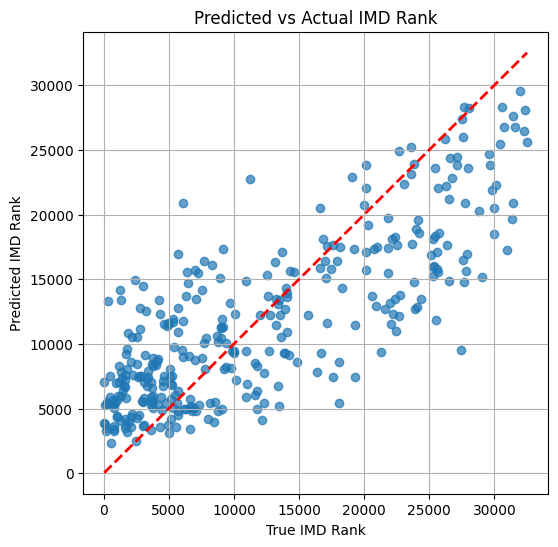

In [31]:
X = np.stack(avg_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

## Build model for different domains of deprivation

In [113]:
def evaluate_imd_model(y_true, y_pred, column, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    #print("Model evaluation metrics:")
#     for k, v in metrics.items():
#         print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so 

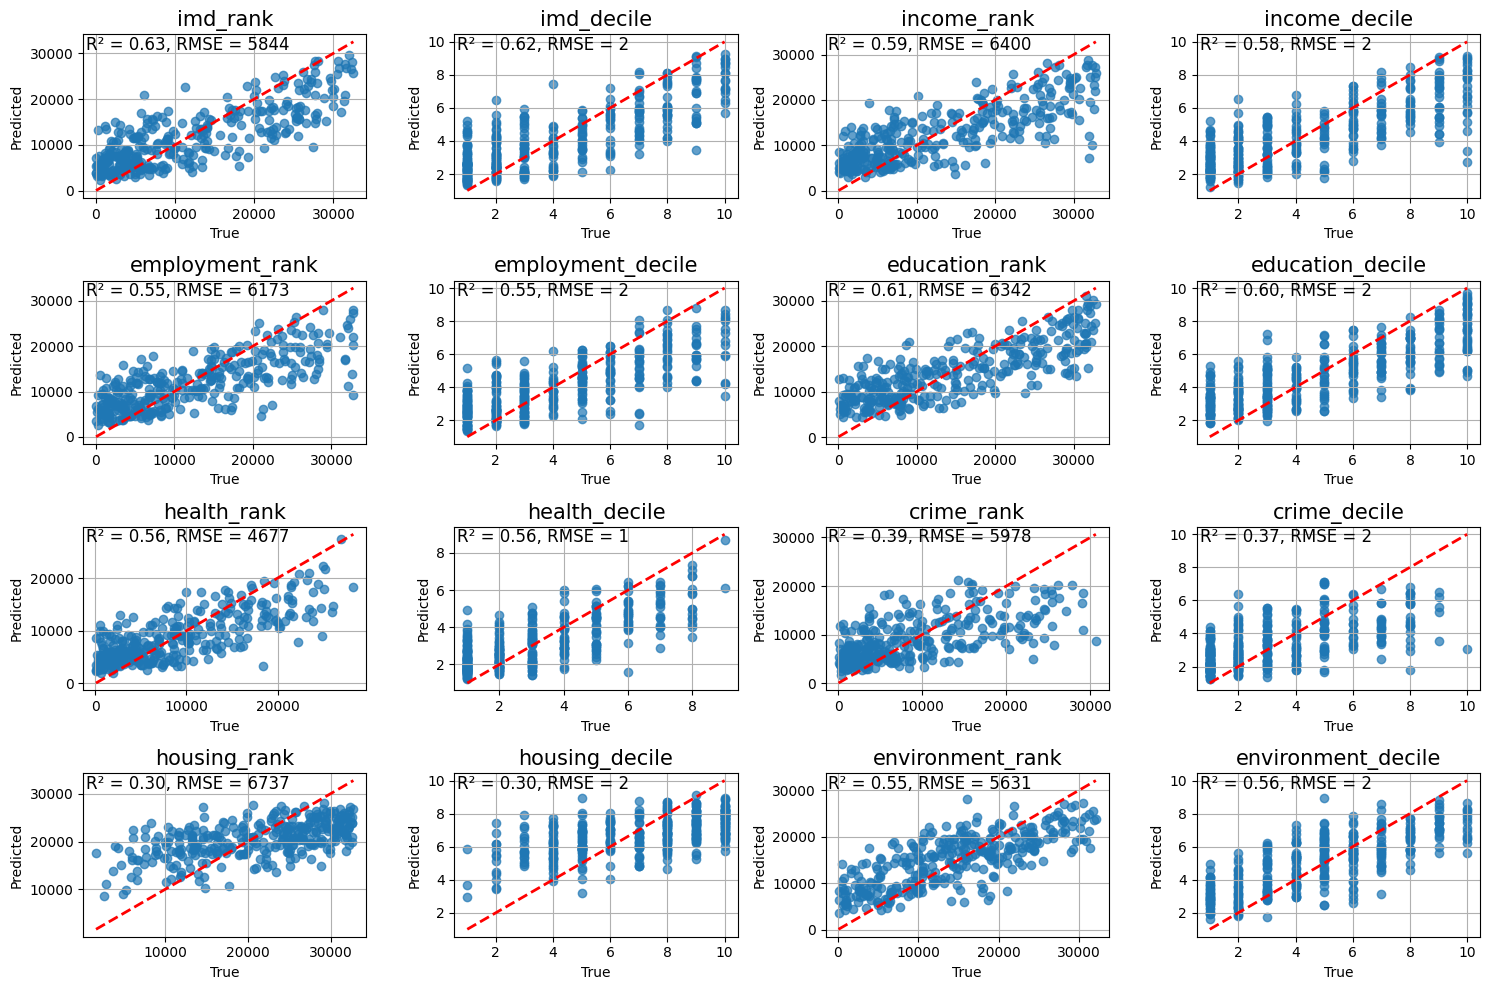

In [114]:
fig, axs=plt.subplots(ncols=4, nrows=4, figsize=(15,10))
axs=axs.flatten()
i=0
for column in avg_embeddings_with_imd.columns[5:]:
#     print(column)
    x = np.stack(avg_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
    y = avg_embeddings_with_imd[column].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a model (Random Forest Regressor example)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Usage example:
    metrics = evaluate_imd_model(y_test, y_pred, column, False, True, axs[i])
    i=i+1
    fig.show()
fig.tight_layout()

